## Load and Read the Data

In [71]:
#load required libraries to load and read data

#Model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,BatchNormalization,Dropout,Flatten,Reshape
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy,CategoricalAccuracy
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

#preprocessing
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import librosa
import os
import shutil
import matplotlib.pyplot as plt

dataset_dir = "data"
file_names = ["on",'off']
folder_paths = [os.path.join(dataset_dir, name) for name in file_names]

In [ ]:

labels = []  
file_paths = []
for label, folder_path in enumerate(folder_paths):
    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        if file_path.endswith('.wav'):
            file_paths.append(file_path)
            labels.append(label)

In [4]:
labels[-1]

1

In [7]:
file_paths[0]

'data\\on\\004ae714_nohash_0.wav'

In [6]:
file_paths[-1]

'data\\off\\fffcabd1_nohash_3.wav'

In [17]:
np.unique(labels,return_counts=True)

(array([0, 1]), array([2367, 2357], dtype=int64))

In [9]:
dataset = []
for file in file_paths:
    audio, sr = librosa.load(file)
    mfcc_fea = np.mean(librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40).T, axis=0)
    dataset.append(mfcc_fea)

## Data Preperation to Feed into the Deep Learning Model

In [10]:


X=np.array(dataset)
y=np.array(labels)
y_extra = y.reshape(-1, 1)



In [14]:
X.shape

(4724, 40)

In [11]:
len(X)

4724

In [12]:
len(y)

4724

In [21]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [23]:
print('Shape of X_train',X_train.shape)
print('Shape of X_teset',X_test.shape)
print('Shape of y_train',y_train.shape)
print('Shape of X_test',y_test.shape)


Shape of X_train (3779, 40)
Shape of X_teset (945, 40)
Shape of y_train (3779,)
Shape of X_test (945,)


In [24]:
#reshaping the data
X_train=np.reshape(X_train,(X_train.shape[0],10,4,1))

X_test=np.reshape(X_test,(X_test.shape[0],10,4,1))

In [83]:
X_test.shape

(945, 10, 4, 1)

In [25]:
X_train.shape

(3779, 10, 4, 1)

Convert the target labels to one hot encoded(categorical) format 

In [ ]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

## Building Model

In [27]:
CONFIGURATIONS = {
    'INPUT_SHAPE':(10,4,1)
}

In [28]:
CONFIGURATIONS['INPUT_SHAPE']

(10, 4, 1)

In [100]:
audio_model = Sequential([
    Reshape(CONFIGURATIONS['INPUT_SHAPE'],input_shape = (10,4,1)),
    Flatten(),
    Dense(512,activation='relu'),
    BatchNormalization(),
    Dense(512,activation='relu'),
    Dense(128,activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(128,activation='relu'),
    BatchNormalization(),
    Dense(64,activation='relu'),
    Dropout(0.2),
    Dense(32,activation='relu'),
    BatchNormalization(),
    Dense(32,activation='relu'),
    Dense(16,activation='relu'),
    Dense(1,activation='sigmoid')
])

In [101]:
audio_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_4 (Reshape)         (None, 10, 4, 1)          0         
                                                                 
 flatten_4 (Flatten)         (None, 40)                0         
                                                                 
 dense_33 (Dense)            (None, 512)               20992     
                                                                 
 batch_normalization_15 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dense_34 (Dense)            (None, 512)               262656    
                                                                 
 dense_35 (Dense)            (None, 128)               65664     
                                                      

In [102]:
from keras.utils import plot_model

### Take a look at the model visual view

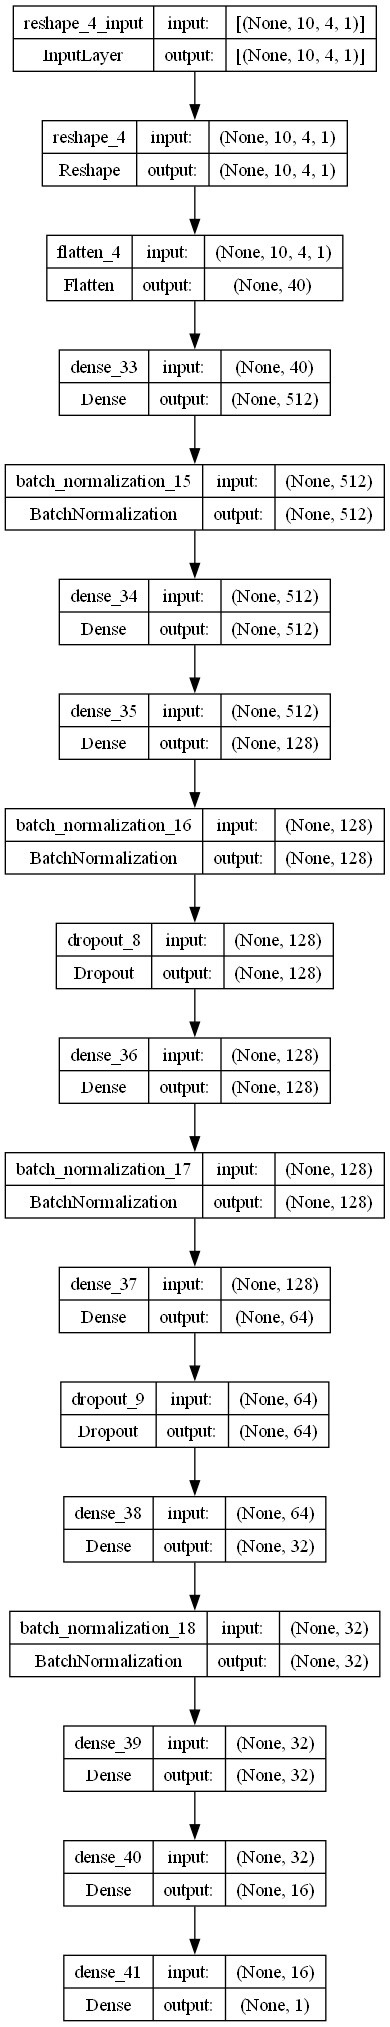

In [103]:
plot_model(audio_model,"audio.png",show_shapes=True)

## Model Compilation with proper loss ,optimizer and accuracy

In [104]:
audio_model.compile(loss=BinaryCrossentropy(),optimizer=Adam(),metrics=[BinaryAccuracy(),CategoricalAccuracy()])

In [105]:
#define the number of batch size (how many sample would each batch will contain)
batch_size = 32

## Write a callback function in order to stop when val_loss is not improving

In [106]:
early_callback = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto',baseline=None, restore_best_weights=True)
model_check_callback = ModelCheckpoint(
    "model",
    monitor='val_loss',
    verbose=0,
    save_best_only=False,
    save_weights_only=False,
    mode='auto',
    save_freq='epoch',
    initial_value_threshold=None
)

In [107]:
executed_model = audio_model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=50,callbacks=[early_callback,model_check_callback])
executed_model

Epoch 1/50
119/119 [==============================] - 8s 51ms/step - loss: 0.6040 - binary_accuracy: 0.6798 - categorical_accuracy: 1.0000 - val_loss: 0.6540 - val_binary_accuracy: 0.6286 - val_categorical_accuracy: 1.0000
Epoch 2/50
119/119 [==============================] - 6s 50ms/step - loss: 0.5284 - binary_accuracy: 0.7335 - categorical_accuracy: 1.0000 - val_loss: 0.4885 - val_binary_accuracy: 0.7630 - val_categorical_accuracy: 1.0000
Epoch 3/50
119/119 [==============================] - 6s 49ms/step - loss: 0.4958 - binary_accuracy: 0.7610 - categorical_accuracy: 1.0000 - val_loss: 0.5001 - val_binary_accuracy: 0.7704 - val_categorical_accuracy: 1.0000
Epoch 4/50
119/119 [==============================] - 6s 52ms/step - loss: 0.4794 - binary_accuracy: 0.7775 - categorical_accuracy: 1.0000 - val_loss: 0.5342 - val_binary_accuracy: 0.7386 - val_categorical_accuracy: 1.0000
Epoch 5/50
119/119 [==============================] - 6s 49ms/step - loss: 0.4725 - binary_accuracy: 0.7761 

## Performance Analysis

In [69]:
executed_model

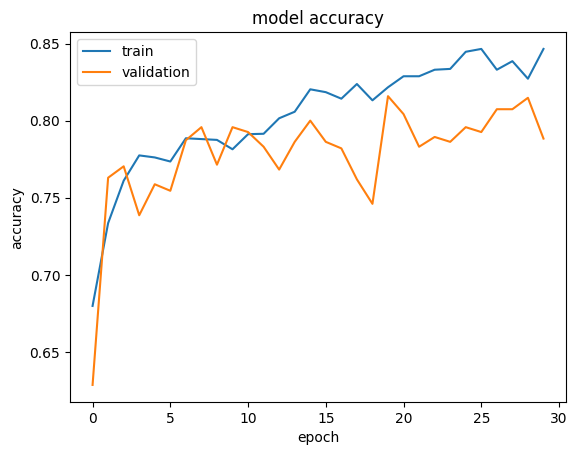

In [108]:
plt.plot(executed_model.history['binary_accuracy'])

plt.plot(executed_model.history['val_binary_accuracy'])

plt.title('model accuracy')

plt.ylabel('accuracy')

plt.xlabel('epoch')

plt.legend(['train', 'validation'], loc='upper left')

plt.show()



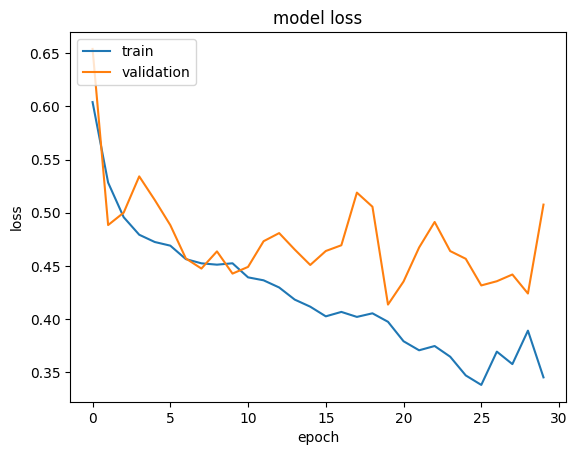

In [109]:
plt.plot(executed_model.history['loss'])

plt.plot(executed_model.history['val_loss'])

plt.title('model loss')

plt.ylabel('loss')

plt.xlabel('epoch')

plt.legend(['train', 'validation'], loc='upper left')

plt.show()

## Load Saved model

In [110]:
from tensorflow import keras

In [111]:
saved_model = keras.models.load_model('model')

In [112]:
saved_model.predict(X_test)

30/30 [==============================] - 1s 14ms/step


array([[0.45143977],
       [0.9945162 ],
       [0.9955486 ],
       [0.9196077 ],
       [0.00787925],
       [0.17275278],
       [0.19981731],
       [0.54335105],
       [0.0179916 ],
       [0.3009452 ],
       [0.2570355 ],
       [0.03736969],
       [0.8372552 ],
       [0.06002305],
       [0.12686932],
       [0.7986077 ],
       [0.32368216],
       [0.5124664 ],
       [0.02720496],
       [0.04135749],
       [0.10575257],
       [0.72874004],
       [0.0431316 ],
       [0.10037312],
       [0.13548073],
       [0.07330366],
       [0.959852  ],
       [0.09060989],
       [0.9759675 ],
       [0.9628788 ],
       [0.6297532 ],
       [0.14191261],
       [0.0554219 ],
       [0.64538515],
       [0.26375797],
       [0.8368743 ],
       [0.10048263],
       [0.01852676],
       [0.0128406 ],
       [0.0615005 ],
       [0.51493853],
       [0.02784444],
       [0.06010075],
       [0.9832375 ],
       [0.23909527],
       [0.5210464 ],
       [0.01748923],
       [0.998

In [89]:
from sklearn.metrics import confusion_matrix

In [90]:
y_pred = saved_model.predict(X_test)

30/30 [==============================] - 0s 13ms/step


In [116]:
final_classes = []
for i in y_pred:
    if i > 0.5:
        final_classes.append(1)
    else:
        final_classes.append(0)

In [117]:
final_classes

[0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,


In [119]:
array_cls = np.array(final_classes)

In [120]:
array_cls

array([0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1,
       0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0,
       0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1,
       1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0,
       1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,

In [123]:
conf_mat = confusion_matrix(y_test,array_cls)

In [126]:
conf_mat

array([[401,  83],
       [ 95, 366]], dtype=int64)

In [122]:
import seaborn as sns

<Axes: >

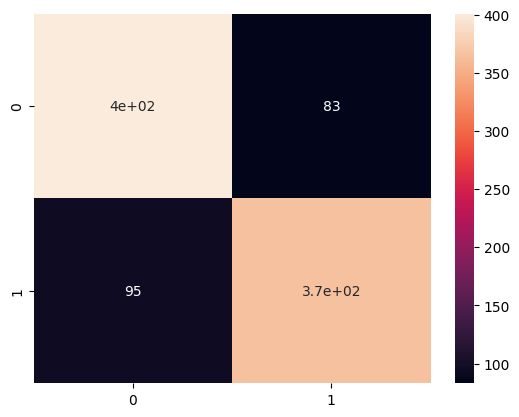

In [130]:
sns.heatmap(conf_mat,annot=True)


In [131]:

audio_file_path = 'data/off/00b01445_nohash_0.wav'


audio_data, sample_rate = librosa.load(audio_file_path, sr=None,) 

In [133]:
sample_rate

16000

In [155]:
test_single_on = X_test[0]

In [156]:
y_test[0]

0

In [147]:
saved_model.predict(test_data_Single) #predicted the correct class 0 (sincee the ouput is less than 0.5)

1/1 [==============================] - 0s 32ms/step


array([[0.45140815]], dtype=float32)

In [157]:
test_single_off = X_test[-5]

y_test[-5]

1

In [158]:
def model_prediction(voice):
    out = saved_model.predict(voice)
    if out[0]  > 0.5:
        print('off')
    else:
        print('On')



In [159]:
model_prediction(test_single_off)

1/1 [==============================] - 0s 32ms/step
off


In [160]:
model_prediction(test_single_on)

1/1 [==============================] - 0s 34ms/step
On


In [154]:

    #predicted the correct class 1 (since the ouput is greater than 0.5)

1/1 [==============================] - 0s 40ms/step
off


## Findings

- Achieved accuracy greater than 80%
- Correctly classified the given inputs
- Still be able to modify by using different strategies